<a href="https://colab.research.google.com/github/shindeparth007/Gold-Price-Forecasting-ML/blob/main/Project_Gold_Price_Forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gold Price Forecasting ML Project
## Author:Parth Shinde and Chidambar Kulkarni
## Guidance By:Prof. Pragnesh Shah
##Start Date:October 2025
#Description: Complete ML prediction for gold price forecasting using Indian market indicators


# Step 1: IMPORTS AND INITIAL SETUP


This code cell imports all the necessary libraries for data manipulation, visualization, machine learning, and time series analysis. It also includes settings for suppressing warnings and customizing plot styles.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


#STEP 2: DATA LOADING AND CLEANING

In [31]:
def load_and_clean_data(csv_file='gold_price_indian_market_data_updated_oct2025'):
    """
    Loading and cleaning the gold price dataset
    """
    print("STEP 2: DATA LOADING AND CLEANING")

    # Loading the data
    try:
        df = pd.read_csv(csv_file)
        print(f"Data loaded successfully from {csv_file}")
        print(f"Dataset shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found!")
        print("Please ensure the CSV file is in the same directory as this collab file.")
        return pd.DataFrame() # Return empty DataFrame instead of None

    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date').sort_index()

    # Displaying basic info to crosscheck
    print(f"   Date range: {df.index[0].date()} to {df.index[-1].date()}")
    print(f"   Gold price range: ₹{df['Target_Gold_Price_INR'].min():.2f} - ₹{df['Target_Gold_Price_INR'].max():.2f}")

    # Checking for the missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"Missing values found:")
        print(missing_values[missing_values > 0])
        df = df.dropna()
        print(f"After removing missing values: {df.shape[0]} samples")
    else:
        print("No missing values found")

    return df

In [32]:
df = load_and_clean_data('gold_price_indian_market_data_updated_oct2025.csv')

STEP 2: DATA LOADING AND CLEANING
Data loaded successfully from gold_price_indian_market_data_updated_oct2025.csv
Dataset shape: (1281, 22)
   Date range: 2020-12-02 to 2025-10-29
   Gold price range: ₹4228.51 - ₹9538.44
No missing values found


# STEP 3: CLASS IMBALANCE CHECK

In [33]:
def class_balance(df):
    """Class imbalance check with visuals and metrics"""
    print("\nSTEP 3: CLASS IMBALANCE ANALYSIS (WITH VISUALS)")
    print("-" * 55)

    # Distribution
    direction_counts = df['Price_Direction'].value_counts()
    direction_pct = df['Price_Direction'].value_counts(normalize=True) * 100

    print("Price Direction Distribution:")
    for direction in direction_counts.index:
        count = direction_counts[direction]
        pct = direction_pct[direction]
        print(f"{direction:>5}: {count:>4} samples ({pct:>5.1f}%)")

    # Balance metrics
    balance_ratio = direction_counts.min() / direction_counts.max()
    print(f"\nBalance Metrics:")
    print(f"Balance Ratio: {balance_ratio:.4f}")
    print(f"Imbalance Ratio: {direction_counts.max()/direction_counts.min():.2f}:1")

    # Assessment text
    if balance_ratio >= 0.8:
        status = "PERFECTLY BALANCED"; note = "No special handling required"
    elif balance_ratio >= 0.6:
        status = "WELL BALANCED"; note = "Proceed normally"
    elif balance_ratio >= 0.4:
        status = "MODERATELY IMBALANCED"; note = "Consider class weights / stratified split"
    elif balance_ratio >= 0.2:
        status = "SIGNIFICANTLY IMBALANCED"; note = "Use SMOTE or class weights"
    else:
        status = "SEVERELY IMBALANCED"; note = "Advanced resampling techniques needed"

    print(f"Assessment: {status}")
    print(f"Recommendation: {note}")

    return direction_counts, direction_pct, balance_ratio, status

In [34]:
# Class balance visualization
def visualize_class_balance(direction_counts, direction_pct, balance_ratio, status):
    """Visualize class balance using bar and pie charts."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar chart
    axes[0].bar(direction_counts.index, direction_counts.values,
                color=['green' if d == 'Up' else 'red' for d in direction_counts.index])
    axes[0].set_title('Class Counts (Up vs Down)')
    axes[0].set_ylabel('Count')

    # Pie chart
    axes[1].pie(direction_pct.values, labels=direction_pct.index,
                autopct='%1.1f%%', colors=['green', 'red'], startangle=90, pctdistance=0.8)
    axes[1].set_title('Class Percentage Distribution')

    # Annotation for balance ratio
    fig.suptitle(f"Class Balance Analysis • Balance Ratio: {balance_ratio:.4f} ({status})",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


STEP 3: CLASS IMBALANCE ANALYSIS (WITH VISUALS)
-------------------------------------------------------
Price Direction Distribution:
   Up:  657 samples ( 51.3%)
 Down:  624 samples ( 48.7%)

Balance Metrics:
Balance Ratio: 0.9498
Imbalance Ratio: 1.05:1
Assessment: PERFECTLY BALANCED
Recommendation: No special handling required


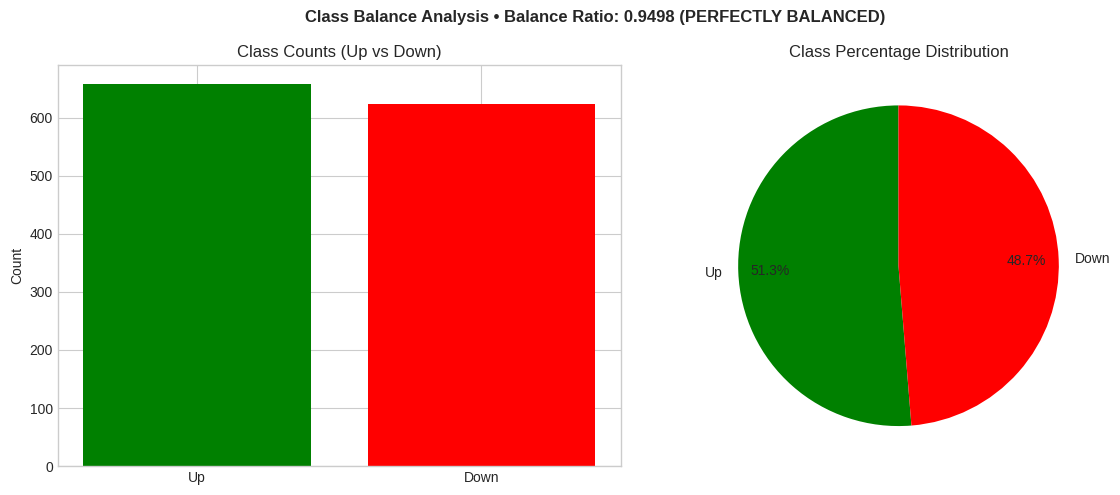

In [35]:
# Call the visualization function with the results from the previous step
direction_counts, direction_pct, balance_ratio, status = class_balance(df.reset_index().assign(Date=df.index).set_index('Date'))
visualize_class_balance(direction_counts, direction_pct, balance_ratio, status)

# STEP 4: EXPLORATORY DATA ANALYSIS


STEP 3: CLASS IMBALANCE ANALYSIS (WITH VISUALS)
-------------------------------------------------------
Price Direction Distribution:
   Up:  657 samples ( 51.3%)
 Down:  624 samples ( 48.7%)

Balance Metrics:
Balance Ratio: 0.9498
Imbalance Ratio: 1.05:1
Assessment: PERFECTLY BALANCED
Recommendation: No special handling required


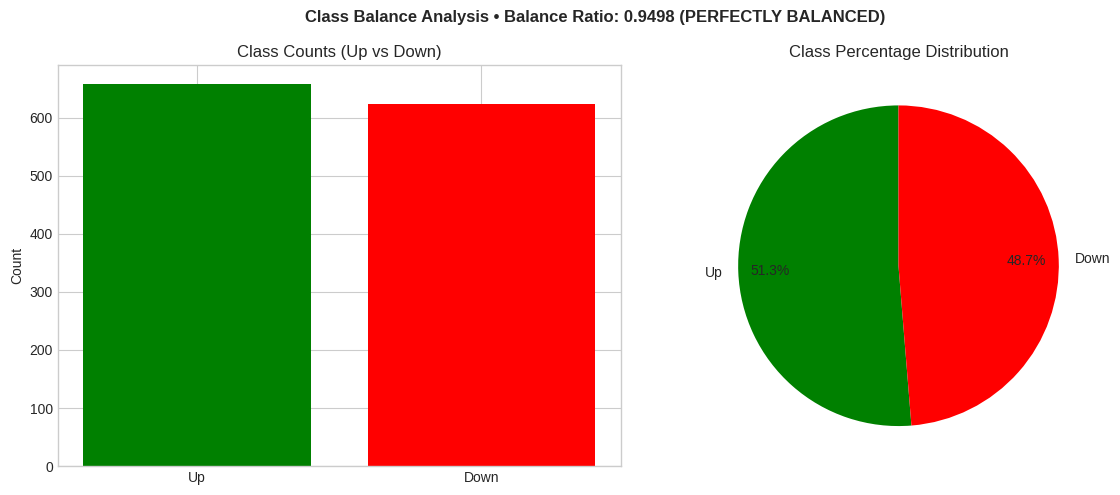

In [36]:
# Call the visualization function with the results from the previous step
direction_counts, direction_pct, balance_ratio, status = class_balance(df.reset_index().assign(Date=df.index).set_index('Date'))
visualize_class_balance(direction_counts, direction_pct, balance_ratio, status)

##STEP 4A: EDA = OVERVIEW & DATA QUALITY

 This step provides an essential overview of the dataset's structure, the basic characteristics of target variable, and checks for missing data, concluding with a visualization of the gold price trend over time.

In [37]:
def eda_overview_and_quality(df):
    print("\nSTEP 4A: EDA = OVERVIEW & DATA QUALITY")
    print("-" * 45)

    print(f"Dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"Date Range: {df.index[0].date()} → {df.index[-1].date()}")

    # Target statistics
    tgt = df['Target_Gold_Price_INR']
    print("\nTarget (Gold Price INR) Summary:")
    print(f"Mean: ₹{tgt.mean():,.2f}")
    print(f"Median: ₹{tgt.median():,.2f}")
    print(f"Std Dev: ₹{tgt.std():,.2f}")
    print(f"Range: ₹{tgt.min():,.2f} - ₹{tgt.max():,.2f}")

    # Missing values
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values across columns")
    else:
        print("Missing values detected:")
        print(missing[missing > 0])

    # Time series plot
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df['Target_Gold_Price_INR'], color='gold')
    plt.title('Gold Price (INR) Over Time')
    plt.ylabel('₹ per gram')
    plt.grid(True, alpha=0.3)
    plt.show()

In [38]:
def eda_features_correlations(df):
    print("\nSTEP 4B: EDA • FEATURE GROUPS & CORRELATIONS")
    print("-" * 50)

    # Feature groups
    price_features = [c for c in df.columns if 'Gold_' in c and c.endswith('INR')]
    market_features = ['NIFTY_50', 'India_VIX', 'INR_Index', 'USD_INR_Rate', 'Indian_Bond_10Y', 'Crude_Oil_Brent']

    print(f"Price Features: {len(price_features)} found")
    print(f"Market Indicators: {len([c for c in market_features if c in df.columns])} found")

    # Correlation heatmap
    corr_features = ['Target_Gold_Price_INR', 'NIFTY_50', 'India_VIX', 'USD_INR_Rate',
                     'Indian_Bond_10Y', 'INR_Index', 'Crude_Oil_Brent']
    corr = df[corr_features].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0, square=True,
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Matrix (Key Predictors vs Gold Price)')
    plt.show()

    # Key relationships
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].scatter(df['NIFTY_50'], df['Target_Gold_Price_INR'], alpha=0.5, color='green')
    axes[0].set_title('Gold Price vs NIFTY 50')
    z = np.polyfit(df['NIFTY_50'], df['Target_Gold_Price_INR'], 1)
    axes[0].plot(df['NIFTY_50'], np.poly1d(z)(df['NIFTY_50']), 'r--', alpha=0.8)

    axes[1].scatter(df['USD_INR_Rate'], df['Target_Gold_Price_INR'], alpha=0.5, color='purple')
    axes[1].set_title('Gold Price vs USD/INR')
    z2 = np.polyfit(df['USD_INR_Rate'], df['Target_Gold_Price_INR'], 1)
    axes[1].plot(df['USD_INR_Rate'], np.poly1d(z2)(df['USD_INR_Rate']), 'r--', alpha=0.8)

    for ax in axes:
        ax.set_xlabel(ax.get_title().split(' vs ')[1])
        ax.set_ylabel('Gold Price (₹/gram)')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [39]:
def eda_distribution_seasonality(df):
    print("\nSTEP 4C: EDA • DISTRIBUTION, OUTLIERS & SEASONALITY")
    print("-" * 55)

    tgt = df['Target_Gold_Price_INR']

    # Distribution
    plt.figure(figsize=(12, 4))
    plt.hist(tgt, bins=50, color='gold', edgecolor='black', alpha=0.8)
    plt.axvline(tgt.mean(), color='red', linestyle='--', label=f"Mean ₹{tgt.mean():.0f}")
    plt.title('Gold Price Distribution (INR)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Outliers (IQR)
    Q1, Q3 = tgt.quantile(0.25), tgt.quantile(0.75)
    IQR = Q3 - Q1
    low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = tgt[(tgt < low) | (tgt > high)]
    print(f"Outliers (IQR method): {len(outliers)} ({len(outliers)/len(tgt)*100:.1f}%)")

    # Seasonality (monthly)
    monthly = df.copy()
    monthly['Month'] = monthly.index.month
    month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    plt.figure(figsize=(14, 4))
    sns.boxplot(x='Month', y='Target_Gold_Price_INR', data=monthly, palette='viridis')
    plt.xticks(ticks=range(12), labels=month_names)
    plt.title('Monthly Seasonality: Gold Price Distribution')
    plt.ylabel('₹ per gram')
    plt.show()


STEP 4A: EDA = OVERVIEW & DATA QUALITY
---------------------------------------------
Dimensions: 1281 rows × 21 columns
Date Range: 2020-12-02 → 2025-10-29

Target (Gold Price INR) Summary:
Mean: ₹6,681.17
Median: ₹6,665.64
Std Dev: ₹1,405.08
Range: ₹4,228.51 - ₹9,538.44
No missing values across columns


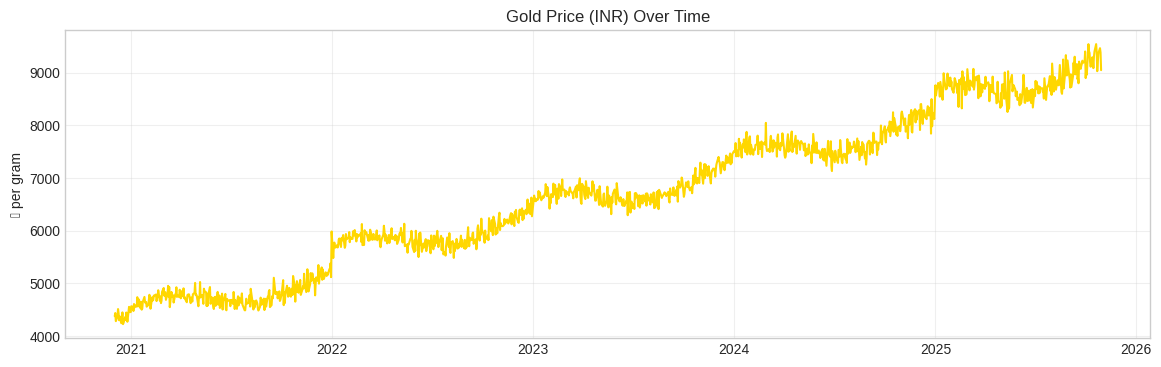

In [40]:
eda_overview_and_quality(df)


STEP 4B: EDA • FEATURE GROUPS & CORRELATIONS
--------------------------------------------------
Price Features: 8 found
Market Indicators: 6 found


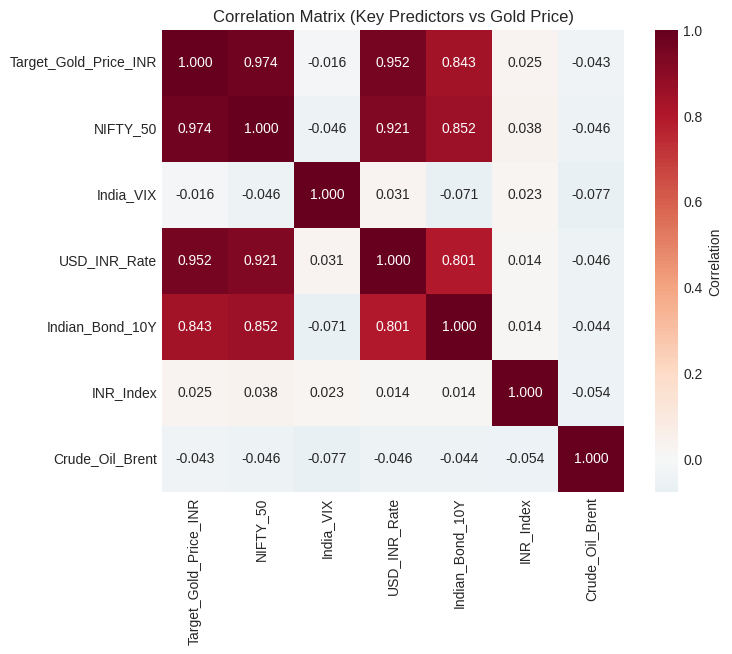

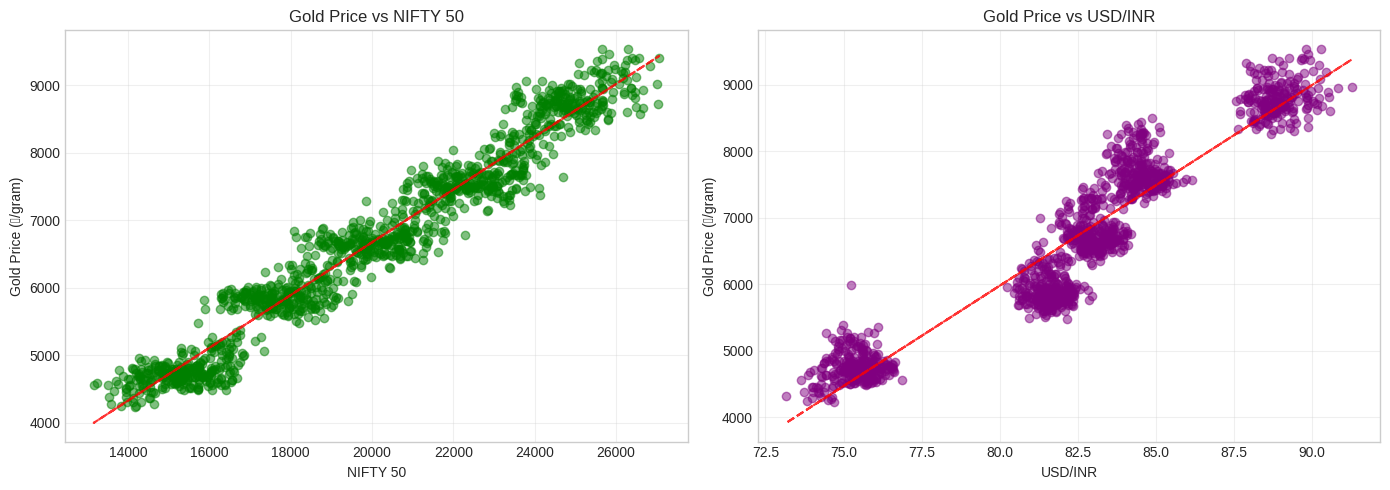

In [41]:
eda_features_correlations(df)


STEP 4C: EDA • DISTRIBUTION, OUTLIERS & SEASONALITY
-------------------------------------------------------


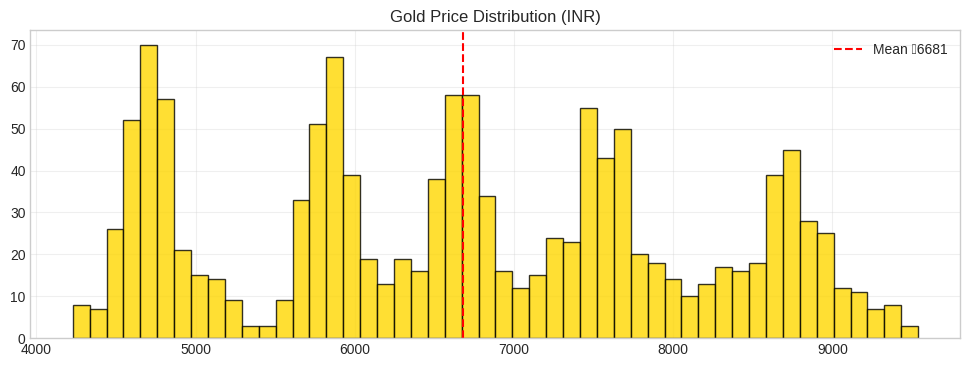

Outliers (IQR method): 0 (0.0%)


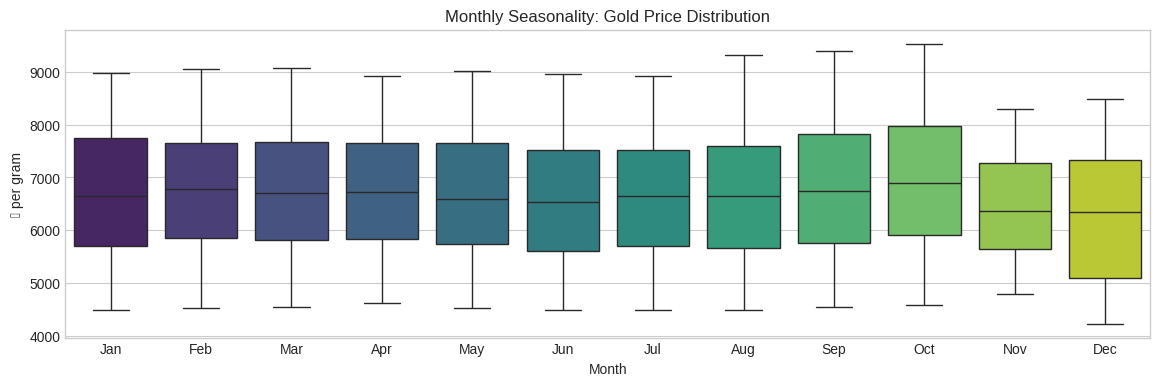

In [42]:
eda_distribution_seasonality(df)

# STEP 5: FEATURE ENGINEERING

This step purpose is to prepare the data into the format required for training the machine learning models, specifically by separating the input features (X) from the target variable (y)

In [43]:
def prepare_features(df):
    """
    Prepare feature matrix and target variable
    """
    print("\nSTEP 5: FEATURE ENGINEERING")
    print("-" * 28)

    # Defining feature columns (Indian market indicators)
    feature_columns = [
        'Gold_Open_INR', 'Gold_High_INR', 'Gold_Low_INR', 'Gold_Volume',
        'NIFTY_50', 'India_VIX', 'INR_Index', 'USD_INR_Rate',
        'Indian_Bond_10Y', 'Crude_Oil_Brent',
        'Gold_MA_5_INR', 'Gold_MA_20_INR', 'Gold_MA_50_INR',
        'Gold_Volatility', 'High_Low_Spread_INR', 'Open_Close_Change_INR'
    ]

    # Prepareing feature matrix and target
    X = df[feature_columns].copy()
    y = df['Target_Gold_Price_INR'].copy()

    print(f"Feature matrix Overview:")
    print(f"Features: {len(feature_columns)}")
    print(f"Samples: {len(X)}")

    # Displaying feature list
    print("\nSelected Features:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i:2d}. {feature}")

    return X, y, feature_columns

In [44]:
X, y, feature_columns = prepare_features(df)


STEP 5: FEATURE ENGINEERING
----------------------------
Feature matrix Overview:
Features: 16
Samples: 1281

Selected Features:
    1. Gold_Open_INR
    2. Gold_High_INR
    3. Gold_Low_INR
    4. Gold_Volume
    5. NIFTY_50
    6. India_VIX
    7. INR_Index
    8. USD_INR_Rate
    9. Indian_Bond_10Y
   10. Crude_Oil_Brent
   11. Gold_MA_5_INR
   12. Gold_MA_20_INR
   13. Gold_MA_50_INR
   14. Gold_Volatility
   15. High_Low_Spread_INR
   16. Open_Close_Change_INR


# Step 6: Model Training and comparision



This step focuses on training different machine learning models on the prepared data and comparing their initial performance on a separate test set.

In [45]:
def train_and_compare_models(X, y):
    """
    Train and compare multiple ML models
    """
    print("\nSTEP 6: MODEL TRAINING AND COMPARISON")
    print("-" * 40)

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Time-based train-test split
    split_date = '2024-01-01'
    train_mask = X.index < split_date
    test_mask = X.index >= split_date

    X_train = X_scaled[train_mask]
    X_test = X_scaled[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]

    print(f"Train-Test Split:")
    print(f"Training: {len(X_train)} samples ({X_train.index[0].date()} to {X_train.index[-1].date()})")
    print(f"Testing: {len(X_test)} samples ({X_test.index[0].date()} to {X_test.index[-1].date()})")

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Support Vector Regression': SVR(kernel='rbf', C=100, gamma=0.001)
    }

    print(f"\nInitialized Models:")
    for name in models.keys():
        print(f"   - {name}")

    return models, X_train, X_test, y_train, y_test, scaler

models, X_train, X_test, y_train, y_test, scaler = train_and_compare_models(X,y)


STEP 6: MODEL TRAINING AND COMPARISON
----------------------------------------
Train-Test Split:
Training: 803 samples (2020-12-02 to 2023-12-29)
Testing: 478 samples (2024-01-01 to 2025-10-29)

Initialized Models:
   - Linear Regression
   - Random Forest
   - Support Vector Regression


#### Train and Predict Models

This sub-step trains each of the initialized models on the training data and then makes predictions on both the training and testing datasets.

In [46]:
def train_and_predict(model, X_train, X_test, y_train):
    """
    Train a model and make predictions.
    """
    print(f"\nTraining and Predicting: {model.__class__.__name__}")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return model, y_train_pred, y_test_pred

results = {}
for name, model in models.items():
    trained_model, y_train_pred, y_test_pred = train_and_predict(model, X_train, X_test, y_train)
    results[name] = {
        'model': trained_model,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }


Training and Predicting: LinearRegression

Training and Predicting: RandomForestRegressor

Training and Predicting: SVR


#### Evaluate Linear Regression

This sub-step calculates and displays the evaluation metrics (R², MAE, MSE) for the Linear Regression model on both the training and testing datasets. It also calculates the overfitting by comparing the training and testing R² scores.

In [47]:
def calculate_metrics(y_true, y_pred, name):
    """
    Calculate evaluation metrics.
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return r2, mae, mse

# Evaluate Linear Regression
lr_model = results['Linear Regression']['model']
lr_y_train_pred = results['Linear Regression']['y_train_pred']
lr_y_test_pred = results['Linear Regression']['y_test_pred']

lr_train_r2, lr_train_mae, lr_train_mse = calculate_metrics(y_train, lr_y_train_pred, 'Linear Regression Train')
lr_test_r2, lr_test_mae, lr_test_mse = calculate_metrics(y_test, lr_y_test_pred, 'Linear Regression Test')

print("\nLinear Regression Metrics:")
print(f"Train R2: {lr_train_r2:.4f}")
print(f"Test R2:  {lr_test_r2:.4f}")
print(f"Train MAE: ₹{lr_train_mae:.2f}")
print(f"Test MAE:  ₹{lr_test_mae:.2f}")
print(f"Overfitting (R2 diff): {abs(lr_train_r2 - lr_test_r2):.4f}")

results['Linear Regression'].update({
    'train_r2': lr_train_r2,
    'test_r2': lr_test_r2,
    'train_mae': lr_train_mae,
    'test_mae': lr_test_mae,
    'train_mse': lr_train_mse,
    'test_mse': lr_test_mse,
    'predictions': lr_y_test_pred,
    'overfitting': abs(lr_train_r2 - lr_test_r2)
})


Linear Regression Metrics:
Train R2: 0.9804
Test R2:  0.9263
Train MAE: ₹94.95
Test MAE:  ₹132.68
Overfitting (R2 diff): 0.0540


#### Evaluate Support Vector Regression

This sub-step calculates and displays the evaluation metrics (R², MAE, MSE) for the Support Vector Regression model on both the training and testing datasets. It also calculates the overfitting by comparing the training and testing R² scores.

In [48]:
# Evaluate Support Vector Regression
svr_model = results['Support Vector Regression']['model']
svr_y_train_pred = results['Support Vector Regression']['y_train_pred']
svr_y_test_pred = results['Support Vector Regression']['y_test_pred']

svr_train_r2, svr_train_mae, svr_train_mse = calculate_metrics(y_train, svr_y_train_pred, 'Support Vector Regression Train')
svr_test_r2, svr_test_mae, svr_test_mse = calculate_metrics(y_test, svr_y_test_pred, 'Support Vector Regression Test')

print("\nSupport Vector Regression Metrics:")
print(f"Train R2: {svr_train_r2:.4f}")
print(f"Test R2:  {svr_test_r2:.4f}")
print(f"Train MAE: ₹{svr_train_mae:.2f}")
print(f"Test MAE:  ₹{svr_test_mae:.2f}")
print(f"Overfitting (R2 diff): {abs(svr_train_r2 - svr_test_r2):.4f}")

results['Support Vector Regression'].update({
    'train_r2': svr_train_r2,
    'test_r2': svr_test_r2,
    'train_mae': svr_train_mae,
    'test_mae': svr_test_mae,
    'train_mse': svr_train_mse,
    'test_mse': svr_test_mse,
    'predictions': svr_y_test_pred,
    'overfitting': abs(svr_train_r2 - svr_test_r2)
})


Support Vector Regression Metrics:
Train R2: 0.7424
Test R2:  -3.4523
Train MAE: ₹375.91
Test MAE:  ₹1239.34
Overfitting (R2 diff): 4.1948


#### Evaluate Random Forest

This sub-step calculates and displays the evaluation metrics (R², MAE, MSE) for the Random Forest model on both the training and testing datasets. It also calculates the overfitting by comparing the training and testing R² scores.

In [49]:
# Evaluate Random Forest
rf_model = results['Random Forest']['model']
rf_y_train_pred = results['Random Forest']['y_train_pred']
rf_y_test_pred = results['Random Forest']['y_test_pred']

rf_train_r2, rf_train_mae, rf_train_mse = calculate_metrics(y_train, rf_y_train_pred, 'Random Forest Train')
rf_test_r2, rf_test_mae, rf_test_mse = calculate_metrics(y_test, rf_y_test_pred, 'Random Forest Test')

print("\nRandom Forest Metrics:")
print(f"Train R2: {rf_train_r2:.4f}")
print(f"Test R2:  {rf_test_r2:.4f}")
print(f"Train MAE: ₹{rf_train_mae:.2f}")
print(f"Test MAE:  ₹{rf_test_mae:.2f}")
print(f"Overfitting (R2 diff): {abs(rf_train_r2 - rf_test_r2):.4f}")

results['Random Forest'].update({
    'train_r2': rf_train_r2,
    'test_r2': rf_test_r2,
    'train_mae': rf_train_mae,
    'test_mae': rf_test_mae,
    'train_mse': rf_train_mse,
    'test_mse': rf_test_mse,
    'predictions': rf_y_test_pred,
    'overfitting': abs(rf_train_r2 - rf_test_r2)
})


Random Forest Metrics:
Train R2: 0.9969
Test R2:  -2.3930
Train MAE: ₹37.36
Test MAE:  ₹942.65
Overfitting (R2 diff): 3.3900


This code visualizes the predicted gold prices from each model against the actual gold prices from the test set. This plot allows for a visual comparison of how well each model's predictions align with the true values over time, helping to understand their performance and identify any patterns or discrepancies.


Visualization of Model Predictions
----------------------------------------


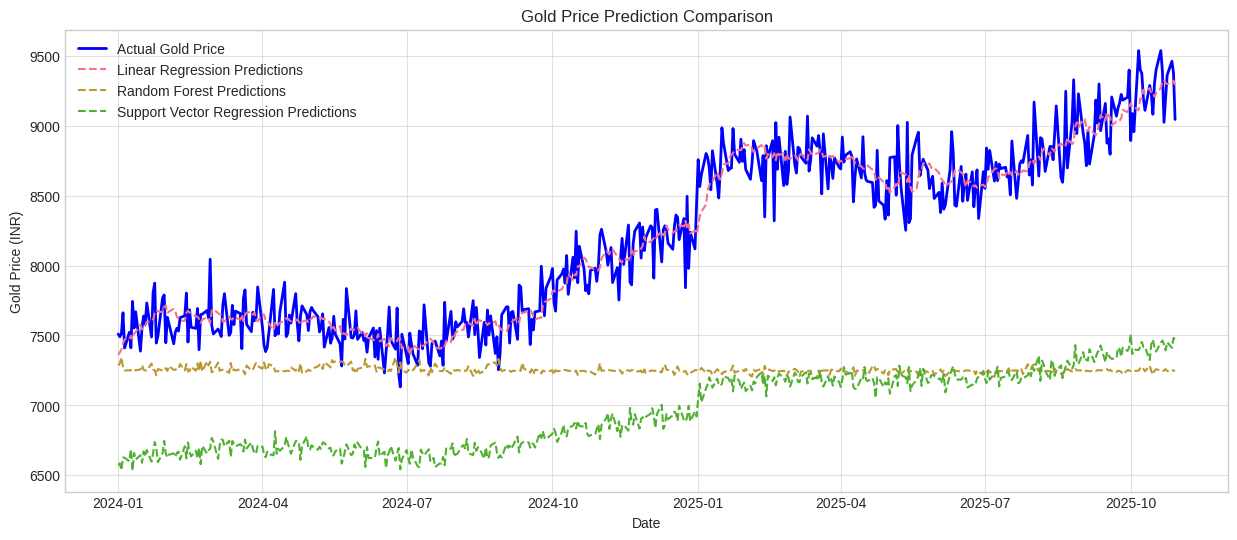

In [50]:
def visualize_results(results, y_test):
    """
    Visualize model predictions against actual values.
    """
    print("\nVisualization of Model Predictions")
    print("-" * 40)

    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, label='Actual Gold Price', color='blue', linewidth=2)

    for name, result in results.items():
        plt.plot(y_test.index, result['predictions'], label=f'{name} Predictions', linestyle='--')

    plt.title('Gold Price Prediction Comparison')
    plt.xlabel('Date')
    plt.ylabel('Gold Price (INR)')
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

visualize_results(results, y_test)

This sub-step summarizes the performance metrics of all trained models in a table format and identifies the best performing model based on the lowest Test Mean Absolute Error (MAE). This provides a clear overview of how each model performed and which one is recommended for further analysis or deployment.

In [51]:
def summarize_results(results):
    """
    Summarize and display model performance metrics.
    """
    print("\nModel Performance Summary")
    print("-" * 40)

    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name,
            'Train_R2': result['train_r2'],
            'Test_R2': result['test_r2'],
            'Test_MAE_INR': result['test_mae'],
            'Overfitting': result['overfitting']
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values(by='Test_MAE_INR').reset_index(drop=True)

    display(comparison_df)

    # Identify the best model based on Test MAE
    best_result = comparison_df.iloc[0]
    print(f"\nBest Model based on Test MAE: {best_result['Model']}")
    print(f"Test MAE: ₹{best_result['Test_MAE_INR']:.2f}")
    print(f"Test R2: {best_result['Test_R2']:.4f}")

    return comparison_df, best_result

comparison_df, best_result = summarize_results(results)


Model Performance Summary
----------------------------------------


,Model,Train_R2,Test_R2,Test_MAE_INR,Overfitting
0,Linear Regression,0.980358,0.926350,132.682785,0.054009
1,Random Forest,0.996923,-2.393047,942.646905,3.389970
2,Support Vector Regression,0.742429,-3.452339,1239.335749,4.194768



Best Model based on Test MAE: Linear Regression
Test MAE: ₹132.68
Test R2: 0.9263


#STEP 7: MODEL VALIDATION



This step focuses on rigorously evaluating the performance of the trained models using techniques specifically designed for time series data. This helps ensure that the models can generalize well to unseen data and provides a more reliable assessment than a single train-test split.

#### STEP 7A: Time Series Cross-Validation

Time Series Cross-Validation is a more robust method for evaluating time series models compared to standard k-fold cross-validation. It respects the temporal order of the data by creating splits where the training data always precedes the testing data. This prevents "data leakage" from the future into the past, which can lead to overly optimistic performance estimates. The results below show the average R² score and its standard deviation across the different splits, providing an indication of the model's consistency.

In [52]:
def time_series_cross_validation(models_dict, X_scaled, y):
    """
    Apply Time Series Cross-Validation
    """
    print("\nSTEP 7A: Time Series Cross-Validation")
    print("-" * 40)

    tscv = TimeSeriesSplit(n_splits=5)

    cv_results = {}
    for name, model_info in models_dict.items():
        model = model_info['model']
        scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring='r2')
        cv_results[name] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
        print(f"   {name}: {scores.mean():.4f} (±{scores.std()*2:.4f})")

    return cv_results

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
cv_results = time_series_cross_validation(results, X_scaled, y)


STEP 7A: Time Series Cross-Validation
----------------------------------------
   Linear Regression: 0.7597 (±0.2775)
   Random Forest: -1.5550 (±2.9249)
   Support Vector Regression: -5.7994 (±3.4051)


#### STEP 7B: Walk-Forward Validation

Walk-Forward Validation is a more realistic evaluation method for time series forecasting models. It simulates a real-world forecasting scenario by training the model on an expanding window of historical data and making predictions for the next period. This process is repeated by "walking forward" through the time series, using the most recent data available for training. This approach is particularly useful for assessing how a model would perform in a production environment where it would be retrained periodically with new data.

In [53]:
def walk_forward_validation(models_dict, X_scaled, y):
    """
    Apply Walk-Forward Validation
    """
    print("\nSTEP 7B: Walk-Forward Validation")
    print("-" * 35)

    window_size = 60
    step_size = 30
    wf_results = {}

    n_samples = len(X_scaled)

    for name, model_info in models_dict.items():
        model = model_info['model']
        wf_scores = []

        # Validate on recent periods only
        start_idx = max(window_size, n_samples - 200)

        for i in range(start_idx, n_samples - step_size, step_size):
            if i + step_size >= n_samples:
                break

            # Define windows
            train_start = max(0, i - window_size * 2)
            train_end = i
            test_start = i
            test_end = min(i + step_size, n_samples)

            # Get data
            X_wf_train = X_scaled.iloc[train_start:train_end]
            y_wf_train = y.iloc[train_start:train_end]
            X_wf_test = X_scaled.iloc[test_start:test_end]
            y_wf_test = y.iloc[test_start:test_end]

            # Train and predict
            from sklearn.base import clone
            model_clone = clone(model)
            model_clone.fit(X_wf_train, y_wf_train)
            y_pred_wf = model_clone.predict(X_wf_test)

            # Score
            score = r2_score(y_wf_test, y_pred_wf)
            wf_scores.append(score)

        if wf_scores:
            wf_mean = np.mean(wf_scores)
            wf_std = np.std(wf_scores)
            wf_results[name] = {
                'mean': wf_mean,
                'std': wf_std,
                'scores': wf_scores
            }
            print(f"   {name}: {wf_mean:.4f} (±{wf_std*2:.4f}) [{len(wf_scores)} windows]")
        else:
            print(f"   {name}: No valid windows")
    return wf_results

wf_results = walk_forward_validation(results, X_scaled, y)


STEP 7B: Walk-Forward Validation
-----------------------------------
   Linear Regression: -1.2435 (±2.3910) [6 windows]
   Random Forest: -0.8892 (±1.8401) [6 windows]
   Support Vector Regression: -5.8370 (±14.8523) [6 windows]


#STEP 8: RESULTS ANALYSIS



This step involves analyzing the performance of the trained models based on various metrics and identifying the best performing model.

#### 8.1 Create Model Performance Comparison Table

This sub-step creates a pandas DataFrame to compare the performance metrics (Train R², Test R², Test MAE, and Overfitting) of the different models and sorts them by Test R² in descending order.

In [54]:
# Create comparison table
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Train_R2': result['train_r2'],
        'Test_R2': result['test_r2'],
        'Test_MAE_INR': result['test_mae'],
        'Overfitting': result['overfitting']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test_R2', ascending=False)

print("MODEL PERFORMANCE COMPARISON:")
print(comparison_df.round(4).to_string(index=False))

MODEL PERFORMANCE COMPARISON:
                    Model  Train_R2  Test_R2  Test_MAE_INR  Overfitting
        Linear Regression    0.9804   0.9263      132.6828       0.0540
            Random Forest    0.9969  -2.3930      942.6469       3.3900
Support Vector Regression    0.7424  -3.4523     1239.3357       4.1948


#### 8.2 Identify the Best Model

This sub-step identifies the best performing model based on the highest Test R² score from the comparison table.

In [55]:
# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_result = results[best_model_name]

print(f"\nBEST MODEL: {best_model_name}")
print(f"   Test R²: {best_result['test_r2']:.4f} ({best_result['test_r2']*100:.2f}% accuracy)")
print(f"   Test MAE: ₹{best_result['test_mae']:.2f}")
print(f"   Test RMSE: ₹{np.sqrt(best_result['test_mse']):.2f}")


BEST MODEL: Linear Regression
   Test R²: 0.9263 (92.63% accuracy)
   Test MAE: ₹132.68
   Test RMSE: ₹166.08


#### 8.3 Analyze Prediction Accuracy

This sub-step calculates and displays the percentage of predictions from the best model that fall within certain absolute error thresholds (±₹50, ±₹100, ±₹200) and percentage error thresholds (±2%, ±5%).

In [56]:
# Prediction accuracy analysis
best_predictions = best_result['predictions']
errors = y_test.values - best_predictions
error_pct = (errors / y_test.values) * 100

print(f"\nPREDICTION ACCURACY:")
print(f"   Within ±₹50: {(np.abs(errors) <= 50).mean()*100:.1f}%")
print(f"   Within ±₹100: {(np.abs(errors) <= 100).mean()*100:.1f}%")
print(f"   Within ±₹200: {(np.abs(errors) <= 200).mean()*100:.1f}%")
print(f"   Within ±2%: {(np.abs(error_pct) <= 2).mean()*100:.1f}%")
print(f"   Within ±5%: {(np.abs(error_pct) <= 5).mean()*100:.1f}%")


PREDICTION ACCURACY:
   Within ±₹50: 22.0%
   Within ±₹100: 46.9%
   Within ±₹200: 76.4%
   Within ±2%: 69.0%
   Within ±5%: 99.0%


#Step 9:  SAVE RESULTS

This section focuses on finalizing the project by saving the results and providing a comprehensive visualization of the best model's performance.

    - Saves the cleaned dataset to `gold_price_cleaned_data_final.csv`.
    - Creates a DataFrame with the actual gold prices from the test set, the predictions from the best model (Linear Regression), and the calculated errors.
    - Saves this predictions DataFrame to `gold_price_predictions_final.csv`.
    - Displays a sample of the last 10 predictions to show the actual vs. predicted prices and the error percentage.

In [57]:
def save_results(df, results, best_model_name, X_test, y_test):
    """
    Save cleaned data and predictions to CSV
    """
    print("\nSTEP 9: SAVING RESULTS")
    print("-" * 23)

    # Save cleaned dataset
    df.to_csv('gold_price_cleaned_data_final.csv')

    # Save predictions
    best_predictions = results[best_model_name]['predictions']
    predictions_df = pd.DataFrame({
        'Date': X_test.index,
        'Actual_Price_INR': y_test.values,
        'Predicted_Price_INR': best_predictions,
        'Error_INR': y_test.values - best_predictions,
        'Error_Percentage': ((y_test.values - best_predictions) / y_test.values) * 100
    })

    predictions_df.to_csv('gold_price_predictions_final.csv', index=False)

    print("Results saved:")
    print("gold_price_cleaned_data_final.csv")
    print("gold_price_predictions_final.csv")

    # Display sample predictions
    print(f"\nSample Predictions (Last 10 days):")
    print("-" * 40)
    sample = predictions_df.tail(10)
    for _, row in sample.iterrows():
        date_str = row['Date'].strftime('%Y-%m-%d')
        actual = row['Actual_Price_INR']
        predicted = row['Predicted_Price_INR']
        error_pct = row['Error_Percentage']
        print(f"   {date_str}: Actual ₹{actual:7.2f} | Pred ₹{predicted:7.2f} | Error {error_pct:5.1f}%")

save_results(df, results, best_model_name, X_test, y_test)


STEP 9: SAVING RESULTS
-----------------------
Results saved:
gold_price_cleaned_data_final.csv
gold_price_predictions_final.csv

Sample Predictions (Last 10 days):
----------------------------------------
   2025-10-16: Actual ₹9304.47 | Pred ₹9208.15 | Error   1.0%
   2025-10-17: Actual ₹9399.67 | Pred ₹9233.63 | Error   1.8%
   2025-10-20: Actual ₹9538.44 | Pred ₹9269.39 | Error   2.8%
   2025-10-21: Actual ₹9390.40 | Pred ₹9322.49 | Error   0.7%
   2025-10-22: Actual ₹9025.53 | Pred ₹9323.96 | Error  -3.3%
   2025-10-23: Actual ₹9190.27 | Pred ₹9305.68 | Error  -1.3%
   2025-10-24: Actual ₹9362.34 | Pred ₹9299.95 | Error   0.7%
   2025-10-27: Actual ₹9462.02 | Pred ₹9305.80 | Error   1.7%
   2025-10-28: Actual ₹9378.44 | Pred ₹9323.33 | Error   0.6%
   2025-10-29: Actual ₹9045.43 | Pred ₹9291.48 | Error  -2.7%


#Step 10: Final Visualisation

    - Generates a plot with two subplots:

        - The top subplot shows the actual gold prices from the test set plotted against the predicted prices from the Linear Regression
         model over time. This allows for a visual comparison of how closely the predictions track the actual values.

        - The bottom subplot displays the prediction errors over time, highlighting when the model overestimates (red bars) or
         underestimates (green bars) the gold price.

    - Prints a final summary of the project, including the best model identified, its accuracy (Test R²),
     and the average error (Test MAE).

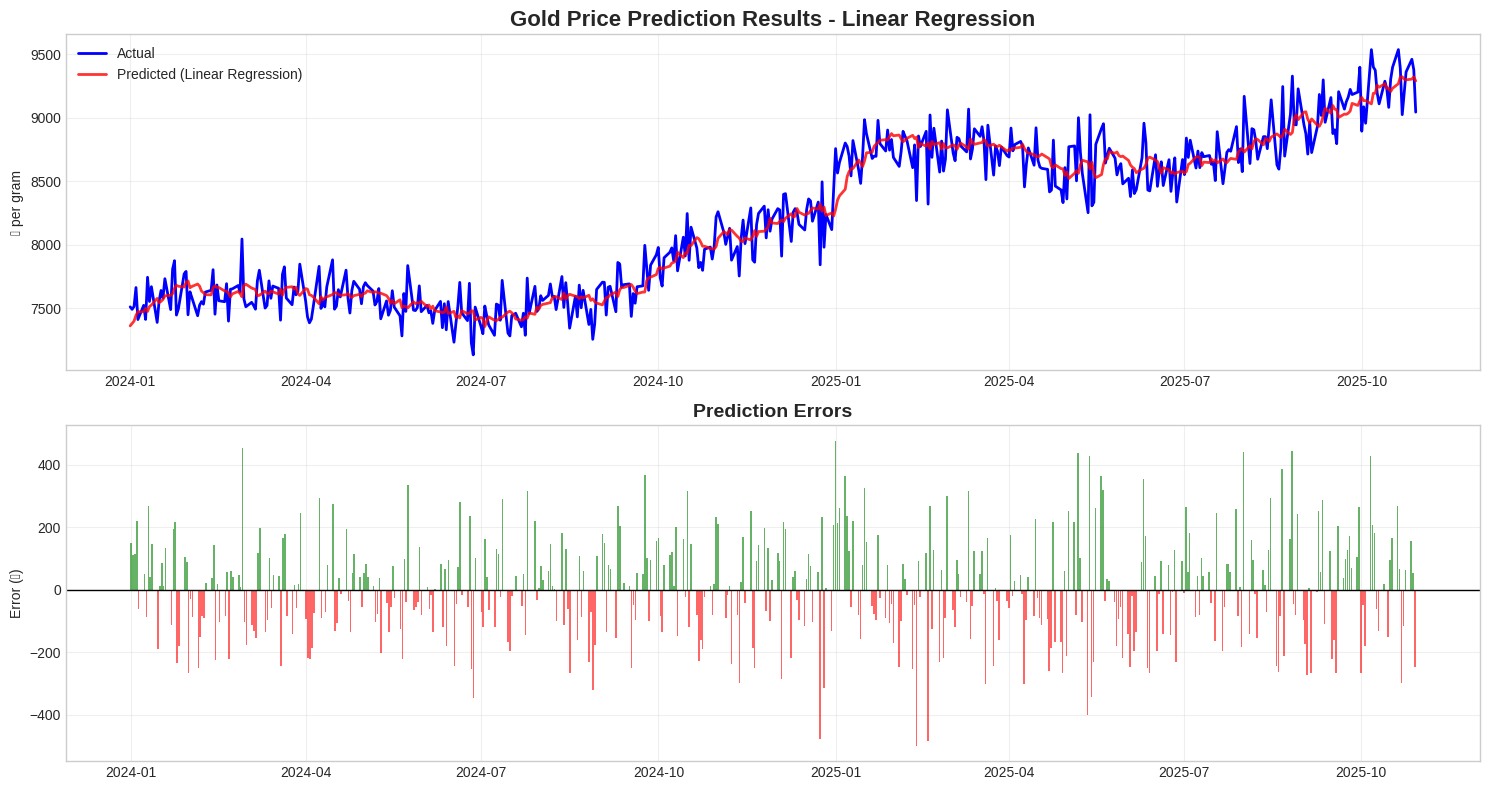


 GOLD PRICE FORECASTING PROJECT COMPLETED SUCCESSFULLY!
Best Model: Linear Regression
Accuracy: 92.63%
Average Error: ₹132.68


In [58]:
    # Final visualization
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.plot(X_test.index, y_test.values, label='Actual', color='blue', linewidth=2)
    plt.plot(X_test.index, best_result['predictions'], label=f'Predicted ({best_model_name})',
             color='red', linewidth=2, alpha=0.8)
    plt.title(f'Gold Price Prediction Results - {best_model_name}', fontsize=16, fontweight='bold')
    plt.ylabel('₹ per gram')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    errors = y_test.values - best_result['predictions']
    plt.bar(X_test.index, errors, color=['green' if e >= 0 else 'red' for e in errors], alpha=0.6)
    plt.title('Prediction Errors', fontsize=14, fontweight='bold')
    plt.ylabel('Error (₹)')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print(" GOLD PRICE FORECASTING PROJECT COMPLETED SUCCESSFULLY!")
    print("="*70)
    print(f"Best Model: {best_model_name}")
    print(f"Accuracy: {best_result['test_r2']*100:.2f}%")
    print(f"Average Error: ₹{best_result['test_mae']:.2f}")
    print("="*70)

#Gold Price Prediction

In [59]:
# --- Load your predictions CSV ---
csv_path = "gold_price_predictions_final.csv"  # Change to your file path
df = pd.read_csv(csv_path)

# --- Required columns ---
actual_col = "Actual_Price_INR"
pred_col = "Predicted_Price_INR"

In [60]:
# --- Calculate Metrics ---
y_true = df[actual_col].values
y_pred = df[pred_col].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)
print("=== Gold Price Prediction Evaluation ===")
print(f"Samples evaluated: {len(y_true)}")
print(f"Mean Absolute Error (MAE): ₹{mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ₹{rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R^2 Score: {r2:.4f}")

=== Gold Price Prediction Evaluation ===
Samples evaluated: 478
Mean Absolute Error (MAE): ₹132.68
Root Mean Squared Error (RMSE): ₹166.08
Mean Absolute Percentage Error (MAPE): 1.61%
R^2 Score: 0.9263


In [61]:
# --- Error Analysis ---
errors = y_true - y_pred
within_50 = (np.abs(errors) <= 50).mean() * 100
within_100 = (np.abs(errors) <= 100).mean() * 100
within_200 = (np.abs(errors) <= 200).mean() * 100
print(f"\nAccuracy breakdown:")
print(f"Within ±₹50: {within_50:.1f}% of predictions")
print(f"Within ±₹100: {within_100:.1f}% of predictions")
print(f"Within ±₹200: {within_200:.1f}% of predictions")


Accuracy breakdown:
Within ±₹50: 22.0% of predictions
Within ±₹100: 46.9% of predictions
Within ±₹200: 76.4% of predictions


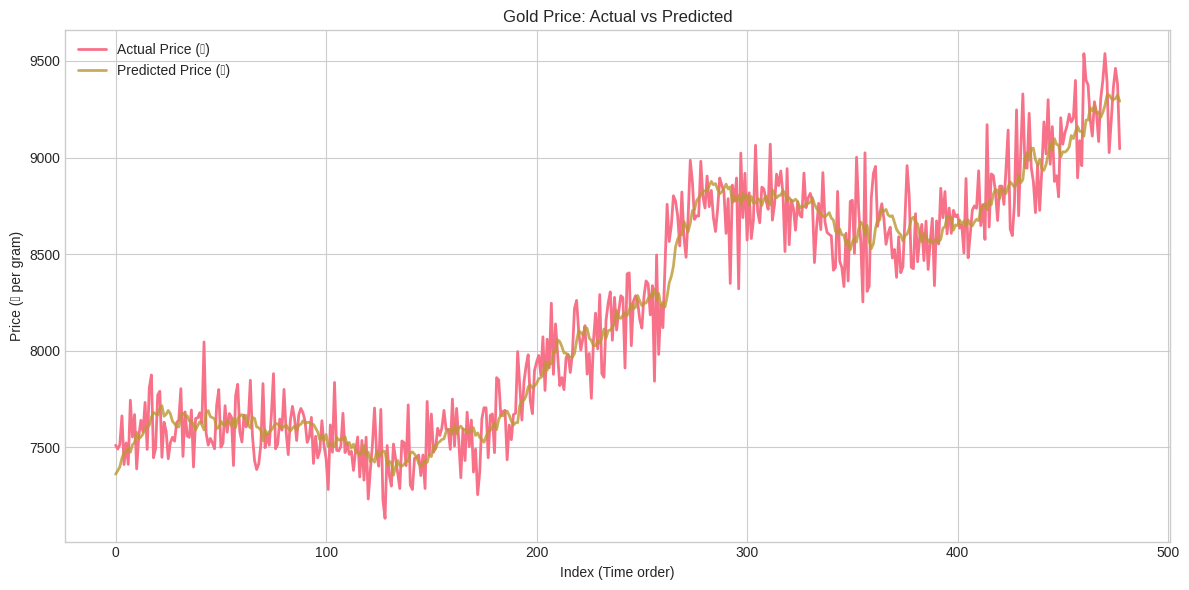

In [62]:
# --- Plot Actual vs Predicted ---
plt.figure(figsize=(12,6))
plt.plot(df[actual_col].values, label="Actual Price (₹)", linewidth=2)
plt.plot(df[pred_col].values, label="Predicted Price (₹)", linewidth=2, alpha=0.8)
plt.title("Gold Price: Actual vs Predicted")
plt.xlabel("Index (Time order)")
plt.ylabel("Price (₹ per gram)")
plt.legend()
plt.tight_layout()
plt.show()

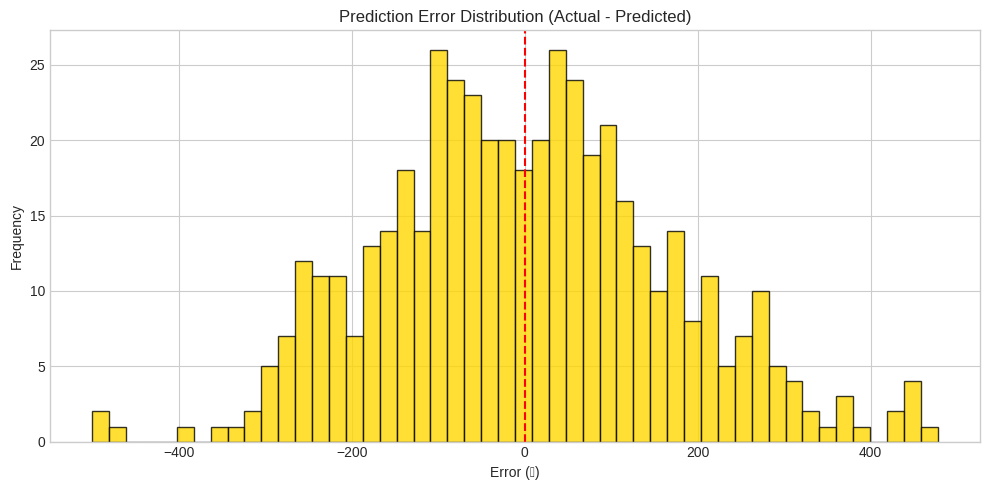

In [63]:
# --- Plot Error Distribution ---
plt.figure(figsize=(10,5))
plt.hist(errors, bins=50, color="gold", edgecolor="black", alpha=0.8)
plt.title("Prediction Error Distribution (Actual - Predicted)")
plt.xlabel("Error (₹)")
plt.ylabel("Frequency")
plt.axvline(0, color="red", linestyle="--")
plt.tight_layout()
plt.show()

This cell parses the 'Date' column as datetime objects, which is necessary for date-based filtering.

In [64]:
# --- Parse date columns if needed ---
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])

This cell sets the target date you want to retrieve the prediction for. You can change the `target_date` variable to any date in your predictions file in `yyyy-mm-dd` format.

In [65]:
# --- Input the target date you want ---
# Format: yyyy-mm-dd (for example, "2025-07-16")
target_date = "2025-09-29"

This cell filters the DataFrame to find the row corresponding to the `target_date` and then extracts and prints the actual and predicted prices for that date. It also handles cases where no prediction is found for the specified date.

In [66]:
# --- Retrieve prediction for the date ---
result = df[df['Date'] == target_date]

if not result.empty:
    actual = result['Actual_Price_INR'].values[0] if 'Actual_Price_INR' in df.columns else None
    predicted = result['Predicted_Price_INR'].values[0] if 'Predicted_Price_INR' in df.columns else None
    print(f"Prediction for {target_date}:")
    print(f"  Predicted Price (₹/gram): {predicted:.2f}")
    if actual is not None:
        print(f"  Actual Price    (₹/gram): {actual:.2f}")
        print(f"  Error (Actual - Predicted): {actual - predicted:.2f}")
else:
    print(f"No prediction found for {target_date}.")

Prediction for 2025-09-29:
  Predicted Price (₹/gram): 9098.19
  Actual Price    (₹/gram): 9203.73
  Error (Actual - Predicted): 105.54
